# Experiment on Features(3), CatBoost Model
Now that we see some features are contributing a lot, we wanna make another assumption:  
    - CatBoost model allow people to determine feature interaction, meaning we can set rules for tree growing: only A, B can grow in one tree, and A,C cannot be set into the same tree, etc.  
    - Is it possible, that we decompose the model and get better result, aka separate features to 2 groups and build 2 models, and combine them together?

In [2]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import json
import pandas as pd
import math

In [2]:
# the evaluation metric
class EbayMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            cur_approx = round(approx[i])
            residual = int(target[i] - cur_approx)
            if residual < 0:
                error_sum += w * -0.6 * residual
            else:
                error_sum += w * 0.4 * residual

        return error_sum, weight_sum

## Full model
We randomly select a submodel and calculate its loss score.

In [4]:
# prepare the data
train_set = pd.read_csv('../data/subtrain/train_1.tsv', sep='\t')
train_set['cross_city'] = train_set['cross_city'].astype('int')
train_set['cross_state'] = train_set['cross_state'].astype('int')
train_set['sender_state'] = train_set['sender_state'].astype('int')
train_set['receive_state'] = train_set['receive_state'].astype('int')
valid_set = pd.read_csv('../data/subtrain/valid_1.tsv', sep='\t')
valid_set['cross_city'] = valid_set['cross_city'].astype('int')
valid_set['cross_state'] = valid_set['cross_state'].astype('int')
valid_set['sender_state'] = valid_set['sender_state'].astype('int')
valid_set['receive_state'] = valid_set['receive_state'].astype('int')

In [5]:
x_train = train_set.drop(['record_number', 'target'], axis=1)
y_train = train_set.target
x_valid = valid_set.drop(['record_number', 'target'], axis=1)
y_valid = valid_set.target

In [7]:
cat_index = []
cat_set = set({"shipment_method_id", "category_id", "bt", "package_size", "cross_city", 
"cross_state", "sender_state", "receive_state", "isNextDay", "isHoliday"})

for idx, cn in enumerate(x_train.columns):
    if cn in cat_set:
        cat_index.append(idx)

train_pool = Pool(x_train, 
              y_train, 
              cat_features=cat_index,
              feature_names=list(x_train.columns))
test_pool = Pool(x_valid,
             y_valid,
             cat_features=cat_index,
             feature_names=list(x_valid.columns))

In [8]:
model = CatBoostRegressor(iterations=1000, 
                          depth = 12,
                          border_count=254,
                          learning_rate=1, 
                          loss_function='RMSE',
                          random_strength=1,
                          one_hot_max_size=8,
                          l2_leaf_reg=3,
                          grow_policy='SymmetricTree',
                          eval_metric=EbayMetric())

In [9]:
model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True)

0:	learn: 0.4286172	test: 0.4283220	best: 0.4283220 (0)	total: 6.25s	remaining: 1h 44m 8s
1:	learn: 0.4240725	test: 0.4236370	best: 0.4236370 (1)	total: 10.6s	remaining: 1h 28m 13s
2:	learn: 0.4221868	test: 0.4214966	best: 0.4214966 (2)	total: 13.8s	remaining: 1h 16m 39s
3:	learn: 0.4191230	test: 0.4184449	best: 0.4184449 (3)	total: 17.4s	remaining: 1h 12m 10s
4:	learn: 0.4160473	test: 0.4156065	best: 0.4156065 (4)	total: 21.5s	remaining: 1h 11m 27s
5:	learn: 0.4134271	test: 0.4126819	best: 0.4126819 (5)	total: 26.2s	remaining: 1h 12m 22s
6:	learn: 0.4114032	test: 0.4109505	best: 0.4109505 (6)	total: 30.1s	remaining: 1h 11m 6s
7:	learn: 0.4083330	test: 0.4079846	best: 0.4079846 (7)	total: 33.6s	remaining: 1h 9m 29s
8:	learn: 0.4059522	test: 0.4054167	best: 0.4054167 (8)	total: 38.1s	remaining: 1h 9m 55s
9:	learn: 0.4039745	test: 0.4033950	best: 0.4033950 (9)	total: 42s	remaining: 1h 9m 20s
10:	learn: 0.4023869	test: 0.4021226	best: 0.4021226 (10)	total: 46s	remaining: 1h 8m 56s
11:	lea

<AxesSubplot:>

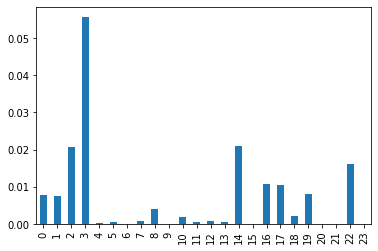

In [10]:
loss_change_score = model.get_feature_importance(data=train_pool,
                                              type = 'LossFunctionChange')
pd.Series(loss_change_score).plot.bar()

<AxesSubplot:>

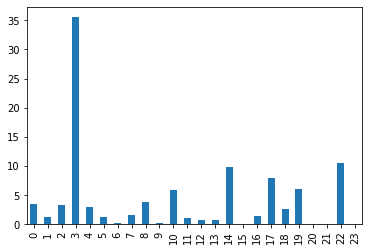

In [11]:
pred_val_change = model.get_feature_importance(data=train_pool,
                                              type = 'PredictionValuesChange')

pd.Series(pred_val_change).plot.bar()

In [14]:
d = {'feature_name':x_train.columns,  'feature_importance':pred_val_change,'loss_change':loss_change_score}
feature_score = pd.DataFrame(data=d)
feature_score.sort_values(by = ['feature_importance'], ascending = False)

,feature_name,feature_importance,loss_change
3,carrier_max_estimate,35.572008,0.055637
22,acc_date,10.517773,0.016043
14,dis,9.758291,0.020911
17,sender_state,7.902511,0.010560
19,acc_hour,5.942981,0.007972
10,package_size,5.914105,0.001895
8,seller_size,3.825894,0.003911
0,shipment_method_id,3.483543,0.007922
2,carrier_min_estimate,3.268749,0.020674
4,category_id,3.002137,0.000402


## Reduced model 1
We now separate features into 2 groups and see how loss changes.

In [23]:
# select feautres
x_train_test = x_train.drop(['isHoliday', 'pay_hour', 'isNextDay', 'cross_city'], axis =1)
x_valid_test = x_valid.drop(['isHoliday', 'pay_hour', 'isNextDay', 'cross_city'], axis =1)

In [24]:
cat_index_test = []
cat_set_test = set({"shipment_method_id", "category_id", "bt", "package_size",  
"cross_state", "sender_state", "receive_state"})

for idx, cn in enumerate(x_train_test.columns):
    if cn in cat_set_test:
        cat_index_test.append(idx)

train_pool = Pool(x_train_test, 
              y_train, 
              cat_features=cat_index_test,
              feature_names=list(x_train_test.columns))
test_pool = Pool(x_valid_test,
             y_valid,
             cat_features=cat_index_test,
             feature_names=list(x_valid_test.columns))

In [25]:
model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.4321508	test: 0.4527646	best: 0.4527646 (0)	total: 5.1s	remaining: 1h 24m 56s
1:	learn: 0.4283485	test: 0.4469304	best: 0.4469304 (1)	total: 9.28s	remaining: 1h 17m 12s
2:	learn: 0.4229813	test: 0.4416151	best: 0.4416151 (2)	total: 12.5s	remaining: 1h 9m 25s
3:	learn: 0.4211707	test: 0.4404959	best: 0.4404959 (3)	total: 16.8s	remaining: 1h 9m 33s
4:	learn: 0.4165335	test: 0.4357467	best: 0.4357467 (4)	total: 21.2s	remaining: 1h 10m 16s
5:	learn: 0.4139448	test: 0.4329263	best: 0.4329263 (5)	total: 25.3s	remaining: 1h 9m 48s
6:	learn: 0.4127582	test: 0.4316201	best: 0.4316201 (6)	total: 29.3s	remaining: 1h 9m 16s
7:	learn: 0.4115530	test: 0.4304623	best: 0.4304623 (7)	total: 33.5s	remaining: 1h 9m 14s
8:	learn: 0.4082776	test: 0.4272135	best: 0.4272135 (8)	total: 38s	remaining: 1h 9m 40s
9:	learn: 0.4056360	test: 0.4246361	best: 0.4246361 (9)	total: 42.1s	remaining: 1h 9m 32s
10:	learn: 0.4040417	test: 0.4238530	best: 0.4238530 (10)	total: 46.8s	remaining: 1h 10m 6s
11:	lear

## Reduced model 2
Now in this model, includes the features that make most contribution to the original model and those related closely with time.

In [27]:
x1_train = x_train[['carrier_max_estimate', 'carrier_min_estimate', 'acc_date', 'acc_hour', 'declared_handling_days']]
x1_valid = x_valid[['carrier_max_estimate', 'carrier_min_estimate', 'acc_date', 'acc_hour', 'declared_handling_days']]
#['shipping_method_id', 'dis', 'sender_state', 'package_size', 'seller_size', 'category_id', 'receive_state', 'cross_state','shipping_fee','item_price','weight','shipping_units','tz_dis','bt','quantity','cross_city']

for idx, cn in enumerate(x1_train.columns):
    if cn in cat_set_test:
        cat_index_test.append(idx)

train_pool = Pool(x1_train, 
              y_train, 
              feature_names=list(x1_train.columns))
test_pool = Pool(x1_valid,
             y_valid,
             feature_names=list(x1_valid.columns))

model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True)

0:	learn: 0.4789128	test: 0.4782384	best: 0.4782384 (0)	total: 777ms	remaining: 12m 55s
1:	learn: 0.4662100	test: 0.4655953	best: 0.4655953 (1)	total: 1.28s	remaining: 10m 39s
2:	learn: 0.4641980	test: 0.4634926	best: 0.4634926 (2)	total: 1.77s	remaining: 9m 47s
3:	learn: 0.4610096	test: 0.4604179	best: 0.4604179 (3)	total: 2.23s	remaining: 9m 16s
4:	learn: 0.4582268	test: 0.4576902	best: 0.4576902 (4)	total: 2.7s	remaining: 8m 58s
5:	learn: 0.4576338	test: 0.4571449	best: 0.4571449 (5)	total: 3.17s	remaining: 8m 45s
6:	learn: 0.4569970	test: 0.4566186	best: 0.4566186 (6)	total: 3.63s	remaining: 8m 34s
7:	learn: 0.4568166	test: 0.4563221	best: 0.4563221 (7)	total: 4.1s	remaining: 8m 28s
8:	learn: 0.4575235	test: 0.4571373	best: 0.4563221 (7)	total: 4.57s	remaining: 8m 23s
9:	learn: 0.4573950	test: 0.4569710	best: 0.4563221 (7)	total: 5.04s	remaining: 8m 18s
10:	learn: 0.4568143	test: 0.4564169	best: 0.4563221 (7)	total: 5.51s	remaining: 8m 15s
11:	learn: 0.4556133	test: 0.4554930	best:

## Reduced model 3
Here are the models with features that, subjectively far away from reduced model 2. They are not related with time.

In [29]:
x2_train = x_train[['shipment_method_id', 'dis', 'sender_state', 'package_size', 'seller_size', 'category_id', 'receive_state', 'cross_state','shipping_fee','item_price','weight','shipping_units','tz_dis','bt','quantity','cross_city']]
x2_valid = x_valid[['shipment_method_id', 'dis', 'sender_state', 'package_size', 'seller_size', 'category_id', 'receive_state', 'cross_state','shipping_fee','item_price','weight','shipping_units','tz_dis','bt','quantity','cross_city']]

cat_index_test = []
cat_set_test = set({"shipment_method_id", "category_id", "bt", "package_size",  
"cross_state", "sender_state", "receive_state"})

for idx, cn in enumerate(x2_train.columns):
    if cn in cat_set_test:
        cat_index_test.append(idx)

train_pool = Pool(x2_train, 
              y_train, 
              cat_features=cat_index_test,
              feature_names=list(x2_train.columns))
test_pool = Pool(x2_valid,
             y_valid,
             cat_features=cat_index_test,
             feature_names=list(x2_valid.columns))

model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True)

0:	learn: 0.4444640	test: 0.4441097	best: 0.4441097 (0)	total: 4.09s	remaining: 1h 8m 2s
1:	learn: 0.4317641	test: 0.4309330	best: 0.4309330 (1)	total: 7.11s	remaining: 59m 9s
2:	learn: 0.4304258	test: 0.4294739	best: 0.4294739 (2)	total: 10.6s	remaining: 58m 57s
3:	learn: 0.4271218	test: 0.4264659	best: 0.4264659 (3)	total: 14.1s	remaining: 58m 20s
4:	learn: 0.4230744	test: 0.4227607	best: 0.4227607 (4)	total: 17.7s	remaining: 58m 43s
5:	learn: 0.4217595	test: 0.4213621	best: 0.4213621 (5)	total: 21.9s	remaining: 1h 32s
6:	learn: 0.4199158	test: 0.4195424	best: 0.4195424 (6)	total: 26.7s	remaining: 1h 3m 10s
7:	learn: 0.4192399	test: 0.4190283	best: 0.4190283 (7)	total: 30.6s	remaining: 1h 3m 10s
8:	learn: 0.4185026	test: 0.4180812	best: 0.4180812 (8)	total: 34.2s	remaining: 1h 2m 41s
9:	learn: 0.4172195	test: 0.4168907	best: 0.4168907 (9)	total: 38.3s	remaining: 1h 3m 12s
10:	learn: 0.4165323	test: 0.4161520	best: 0.4161520 (10)	total: 41.6s	remaining: 1h 2m 19s
11:	learn: 0.4161305	

## Conclusion

Sadly, neither model has a better performance than the original model :(  
    So our following thought is: maybe the features are too few to make further progress? Following that, we investigate how we can invent more features...